# Asset Pricing: Finite State Models


<a id='index-1'></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import quantecon as qe
from numpy.linalg import eigvals, solve

C:\Users\Diogo\Anaconda3\lib\site-packages\numba\np\ufunc\parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10005. The TBB threading layer is disabled.
  warnings.warn(problem)


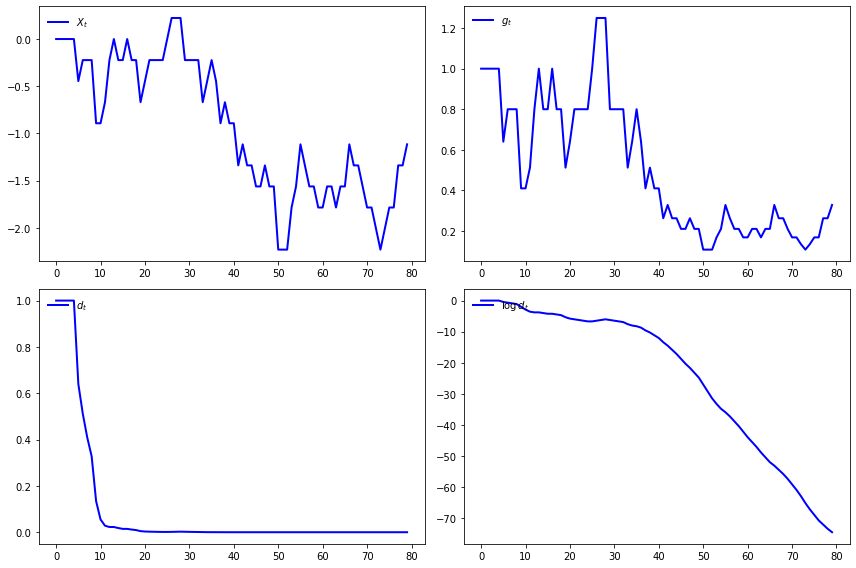

In [2]:
mc = qe.tauchen(0.96, 0.25, n=25)
sim_length = 80

x_series = mc.simulate(sim_length, init=np.median(mc.state_values))
g_series = np.exp(x_series)
d_series = np.cumprod(g_series) # Assumes d_0 = 1

series = [x_series, g_series, d_series, np.log(d_series)]
labels = ['$X_t$', '$g_t$', '$d_t$', r'$\log \, d_t$']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for ax, s, label in zip(axes.flatten(), series, labels):
    ax.plot(s, 'b-', lw=2, label=label)
    ax.legend(loc='upper left', frameon=False)
plt.tight_layout()
plt.show()

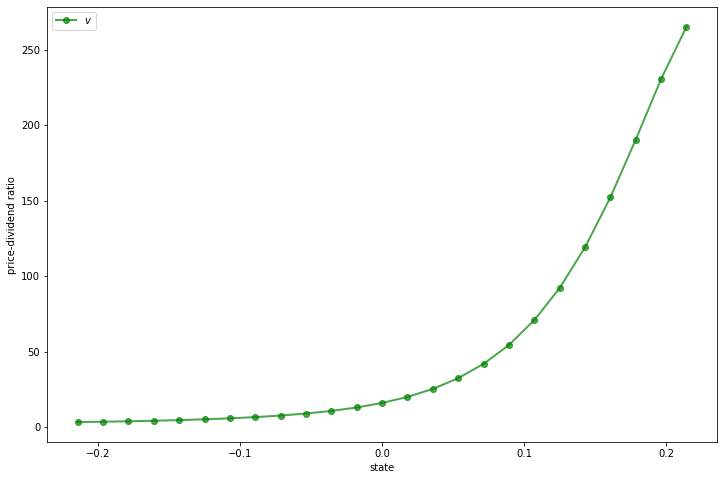

In [3]:
n = 25  # Size of state space
β = 0.9
mc = qe.tauchen(0.96, 0.02, n=n)

K = mc.P * np.exp(mc.state_values)

warning_message = "Spectral radius condition fails"
assert np.max(np.abs(eigvals(K))) < 1 / β,  warning_message

I = np.identity(n)
v = solve(I - β * K, β * K @ np.ones(n))

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(mc.state_values, v, 'g-o', lw=2, alpha=0.7, label='$v$')
ax.set_ylabel("price-dividend ratio")
ax.set_xlabel("state")
ax.legend(loc='upper left')
plt.show()

In [4]:
class AssetPriceModel:
    """
    A class that stores the primitives of the asset pricing model.

    Parameters
    ----------
    β : scalar, float
        Discount factor
    mc : MarkovChain
        Contains the transition matrix and set of state values for the state
        process
    γ : scalar(float)
        Coefficient of risk aversion
    g : callable
        The function mapping states to growth rates

    """
    def __init__(self, β=0.96, mc=None, γ=2.0, g=np.exp):
        self.β, self.γ = β, γ
        self.g = g

        # A default process for the Markov chain
        if mc is None:
            self.ρ = 0.9
            self.σ = 0.02
            self.mc = qe.tauchen(self.ρ, self.σ, n=25)
        else:
            self.mc = mc

        self.n = self.mc.P.shape[0]

    def test_stability(self, Q):
        """
        Stability test for a given matrix Q.
        """
        sr = np.max(np.abs(eigvals(Q)))
        if not sr < 1 / self.β:
            msg = f"Spectral radius condition failed with radius = {sr}"
            raise ValueError(msg)


def tree_price(ap):
    """
    Computes the price-dividend ratio of the Lucas tree.

    Parameters
    ----------
    ap: AssetPriceModel
        An instance of AssetPriceModel containing primitives

    Returns
    -------
    v : array_like(float)
        Lucas tree price-dividend ratio

    """
    # Simplify names, set up matrices
    β, γ, P, y = ap.β, ap.γ, ap.mc.P, ap.mc.state_values
    J = P * ap.g(y)**(1 - γ)

    # Make sure that a unique solution exists
    ap.test_stability(J)

    # Compute v
    I = np.identity(ap.n)
    Ones = np.ones(ap.n)
    v = solve(I - β * J, β * J @ Ones)

    return v

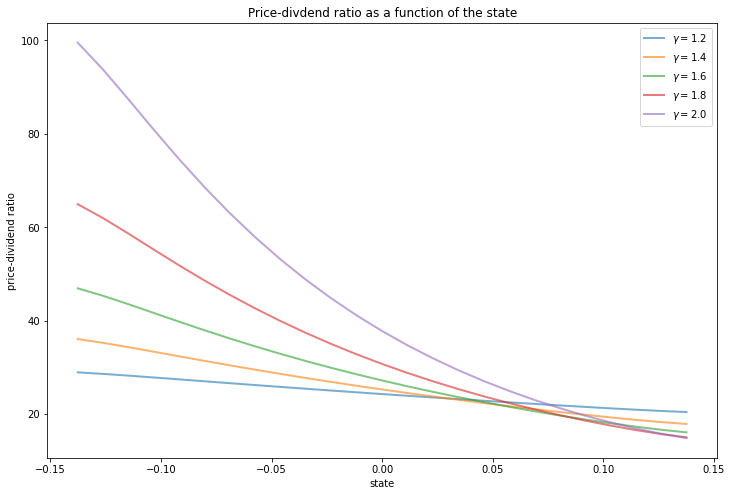

In [5]:
γs = [1.2, 1.4, 1.6, 1.8, 2.0]
ap = AssetPriceModel()
states = ap.mc.state_values

fig, ax = plt.subplots(figsize=(12, 8))

for γ in γs:
    ap.γ = γ
    v = tree_price(ap)
    ax.plot(states, v, lw=2, alpha=0.6, label=rf"$\gamma = {γ}$")

ax.set_title('Price-divdend ratio as a function of the state')
ax.set_ylabel("price-dividend ratio")
ax.set_xlabel("state")
ax.legend(loc='upper right')
plt.show()

In [6]:
def consol_price(ap, ζ):
    """
    Computes price of a consol bond with payoff ζ

    Parameters
    ----------
    ap: AssetPriceModel
        An instance of AssetPriceModel containing primitives

    ζ : scalar(float)
        Coupon of the console

    Returns
    -------
    p : array_like(float)
        Console bond prices

    """
    # Simplify names, set up matrices
    β, γ, P, y = ap.β, ap.γ, ap.mc.P, ap.mc.state_values
    M = P * ap.g(y)**(- γ)

    # Make sure that a unique solution exists
    ap.test_stability(M)

    # Compute price
    I = np.identity(ap.n)
    Ones = np.ones(ap.n)
    p = solve(I - β * M, β * ζ * M @ Ones)

    return p

In [7]:
def call_option(ap, ζ, p_s, ϵ=1e-7):
    """
    Computes price of a call option on a consol bond.

    Parameters
    ----------
    ap: AssetPriceModel
        An instance of AssetPriceModel containing primitives

    ζ : scalar(float)
        Coupon of the console

    p_s : scalar(float)
        Strike price

    ϵ : scalar(float), optional(default=1e-8)
        Tolerance for infinite horizon problem

    Returns
    -------
    w : array_like(float)
        Infinite horizon call option prices

    """
    # Simplify names, set up matrices
    β, γ, P, y = ap.β, ap.γ, ap.mc.P, ap.mc.state_values
    M = P * ap.g(y)**(- γ)

    # Make sure that a unique consol price exists
    ap.test_stability(M)

    # Compute option price
    p = consol_price(ap, ζ)
    w = np.zeros(ap.n)
    error = ϵ + 1
    while error > ϵ:
        # Maximize across columns
        w_new = np.maximum(β * M @ w, p - p_s)
        # Find maximal difference of each component and update
        error = np.amax(np.abs(w - w_new))
        w = w_new

    return w

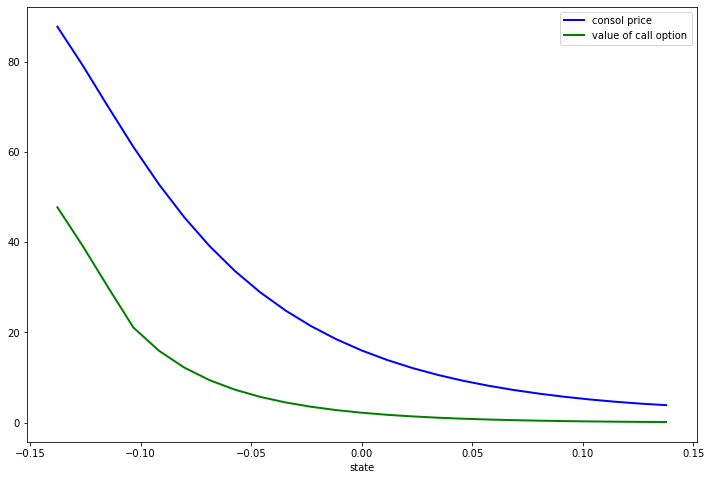

In [8]:
ap = AssetPriceModel(β=0.9)
ζ = 1.0
strike_price = 40

x = ap.mc.state_values
p = consol_price(ap, ζ)
w = call_option(ap, ζ, strike_price)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(x, p, 'b-', lw=2, label='consol price')
ax.plot(x, w, 'g-', lw=2, label='value of call option')
ax.set_xlabel("state")
ax.legend(loc='upper right')
plt.show()

In [9]:
n = 5
P = 0.0125 * np.ones((n, n))
P += np.diag(0.95 - 0.0125 * np.ones(5))
# State values of the Markov chain
s = np.array([0.95, 0.975, 1.0, 1.025, 1.05])
γ = 2.0
β = 0.94

In [10]:
n = 5
P = 0.0125 * np.ones((n, n))
P += np.diag(0.95 - 0.0125 * np.ones(5))
s = np.array([0.95, 0.975, 1.0, 1.025, 1.05])  # State values
mc = qe.MarkovChain(P, state_values=s)

γ = 2.0
β = 0.94
ζ = 1.0
p_s = 150.0

In [11]:
apm = AssetPriceModel(β=β, mc=mc, γ=γ, g=lambda x: x)

In [12]:
tree_price(apm)

array([29.47401578, 21.93570661, 17.57142236, 14.72515002, 12.72221763])

In [13]:
consol_price(apm, ζ)

array([753.87100476, 242.55144082, 148.67554548, 109.25108965,
        87.56860139])

In [14]:
call_option(apm, ζ, p_s)

array([603.87100476, 176.8393343 , 108.67734499,  80.05179254,
        64.30843748])

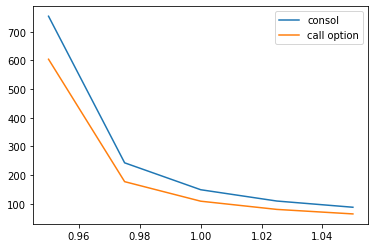

In [15]:
fig, ax = plt.subplots()
ax.plot(s, consol_price(apm, ζ), label='consol')
ax.plot(s, call_option(apm, ζ, p_s), label='call option')
ax.legend()
plt.show()

In [16]:
def finite_horizon_call_option(ap, ζ, p_s, k):
    """
    Computes k period option value.
    """
    # Simplify names, set up matrices
    β, γ, P, y = ap.β, ap.γ, ap.mc.P, ap.mc.state_values
    M = P * ap.g(y)**(- γ)

    # Make sure that a unique solution exists
    ap.test_stability(M)


    # Compute option price
    p = consol_price(ap, ζ)
    w = np.zeros(ap.n)
    for i in range(k):
        # Maximize across columns
        w = np.maximum(β * M @ w, p - p_s)

    return w

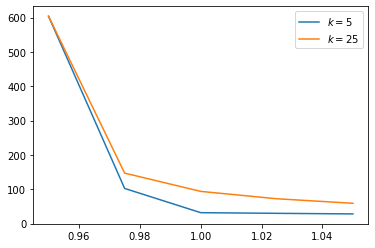

In [17]:
fig, ax = plt.subplots()
for k in [5, 25]:
    w = finite_horizon_call_option(apm, ζ, p_s, k)
    ax.plot(s, w, label=rf'$k = {k}$')
ax.legend()
plt.show()